<a href="https://colab.research.google.com/github/chaeeerish/bootcamp_team/blob/main/deeplearning/efficientdet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import cv2
import matplotlib.pyplot as plt
import os
import random

In [4]:
#이미지 로드
img = cv2.imread('/content/drive/MyDrive/htp_project/img/나무 (96).jpg')
print('img shape:', img.shape)

img shape: (883, 800, 3)


In [5]:
!cat /content/drive/MyDrive/htp_project/xml/나무 (96).xml

/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: `cat /content/drive/MyDrive/htp_project/xml/나무 (96).xml'


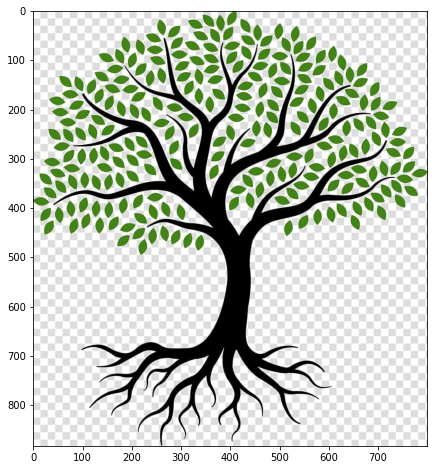

In [6]:
plt.figure(figsize=(8,8))
plt.imshow(img)
plt.show()

In [7]:
!pip install lxml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [37]:
#클래스 이름, box 좌표 list 생성까지만

import os
import xml.etree.ElementTree as ET

#xml load
xml_dir = "/content/drive/MyDrive/htp_project/xml/"
img_dir = "/content/drive/MyDrive/htp_project/img/"

xml_file = os.path.join(xml_dir, '나무 (96).xml')

#xml parsing
tree = ET.parse(xml_file)
root = tree.getroot()

#root 하위에 정보들 가져온다.
image_name = root.find('filename').text
full_image_name = os.path.join(img_dir, image_name)
image_size = root.find('size')
image_width = int(image_size.find('width').text)
image_height = int(image_size.find('height').text)


# 이미지에 존재하는 오브젝트의 바운딩 박스 좌표를 모두 가져온다.
# 오브젝트: 가지, 줄기, 뿌리 총 세 개

objects_list = [] #세 오브젝트들을 한 묶음으로 담는다. 예: object_list[0]에 담긴 값은 0번 이미지에 대한 오브젝트들 (가지, 줄기, 뿌리)
                # 결국 object_list의 인덱스: 이미지 순서

# print('image_size:', (image_width, image_height))
for obj in root.findall('object'): #모든 object
    #object element의 자식 element에서 bndbox를 찾음
    xmlbox = obj.find('bndbox')
    #bndbox element의 자식 element에서 xmin,ymin,xmax,ymax를 찾아 값인 text만 추출 
    x1 = int(xmlbox.find('xmin').text)
    y1 = int(xmlbox.find('ymin').text)
    x2 = int(xmlbox.find('xmax').text)
    y2 = int(xmlbox.find('ymax').text)
    
    bndbox_pos = (x1, y1, x2, y2)
    class_name=obj.find('name').text #1001, 1002, 1003
    object_dict={'class_name': class_name, 'bndbox_pos':bndbox_pos}  #딕셔너리 생성. 예: {'class_name':1001, 'bhdbox_pos':(100, 200, 200, 300)}
    objects_list.append(object_dict) #리스트에 넣는다

for object in objects_list:
  print(object)

{'class_name': '1003', 'bndbox_pos': (87, 664, 624, 883)}
{'class_name': '1002', 'bndbox_pos': (329, 501, 492, 660)}
{'class_name': '1001', 'bndbox_pos': (49, 50, 745, 455)}


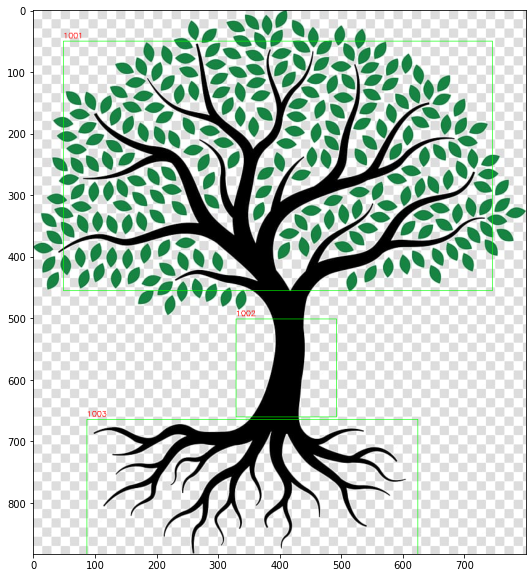

In [46]:
#리스트는 생성하지 않고 box 그려서 보여주는 코드


#xml load
xml_dir = "/content/drive/MyDrive/htp_project/xml/"
img_dir = "/content/drive/MyDrive/htp_project/img/"

xml_file = os.path.join(xml_dir, '나무 (96).xml')

#xml parsing
tree = ET.parse(xml_file)
root = tree.getroot()

#root 하위에 정보들 가져온다.
image_name = root.find('filename').text
full_image_name = os.path.join(img_dir, image_name)
image_size = root.find('size')
image_width = int(image_size.find('width').text)
image_height = int(image_size.find('height').text)

img = cv2.imread(full_image_name)
draw_img = img.copy()
green_color = (0, 255, 0) #박스 컬러
red_color = (0, 0, 255) #라벨 컬러


# print('image_size:', (image_width, image_height))
for obj in root.findall('object'): #모든 object
    #object element의 자식 element에서 bndbox를 찾음
    xmlbox = obj.find('bndbox')
    #bndbox element의 자식 element에서 xmin,ymin,xmax,ymax를 찾아 값인 text만 추출 
    left = int(xmlbox.find('xmin').text)
    top = int(xmlbox.find('ymin').text)
    right = int(xmlbox.find('xmax').text)
    bottom = int(xmlbox.find('ymax').text)

    class_name = obj.find('name').text

    cv2.rectangle(draw_img, (left, top), (right, bottom), color=green_color, thickness=1)
    cv2.putText(draw_img, class_name, (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, red_color, thickness=1)

img_gray = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))
plt.imshow(img_gray)


In [49]:
#efficientDet 모델

import tensorflow as tf
#tensorflow_hub import 수행. 
import tensorflow_hub as hub

In [50]:
module_handle = "https://tfhub.dev/tensorflow/efficientdet/d0/1"
detector_model = hub.load(module_handle)

In [53]:
import time
import numpy as np

img_array_np = img
img_array = img_array_np[np.newaxis, ...]

print(img_array_np.shape, img_array.shape)

start_time = time.time()
result = detector_model(img_array)
print('elapsed time:', time.time()-start_time)

(883, 800, 3) (1, 883, 800, 3)
elapsed time: 1.0985803604125977


In [63]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  print(img.shape, type(img))
  return img

In [62]:
img_tensor = tf.convert_to_tensor(img_array_np, dtype=tf.uint8)[tf.newaxis, ...]
start_time = time.time()

result = detector_model(img_tensor)
print('elapsed time:', time.time()-start_time)

elapsed time: 1.0956664085388184


In [55]:
print(result.keys())
print(result['detection_boxes'].shape, result['detection_classes'].shape,  result['detection_scores'].shape, result['num_detections'])

dict_keys(['detection_scores', 'detection_boxes', 'detection_anchor_indices', 'detection_multiclass_scores', 'raw_detection_scores', 'detection_classes', 'raw_detection_boxes', 'num_detections'])
(1, 100, 4) (1, 100) (1, 100) tf.Tensor([100.], shape=(1,), dtype=float32)


In [57]:
print(result['detection_boxes'])

tf.Tensor(
[[[1.15719438e-02 4.85253818e-02 9.82311368e-01 9.32187557e-01]
  [1.15719438e-02 4.85253818e-02 9.82311368e-01 9.32187557e-01]
  [2.70830691e-02 4.24341336e-02 9.87253785e-01 9.38967466e-01]
  [1.15719438e-02 4.85253818e-02 9.82311368e-01 9.32187557e-01]
  [2.93710530e-02 3.12210284e-02 9.49993849e-01 9.27563787e-01]
  [1.15719438e-02 4.85253818e-02 9.82311368e-01 9.32187557e-01]
  [2.73010433e-02 3.66434567e-02 9.84691620e-01 9.37912881e-01]
  [2.60123312e-02 1.50382267e-02 9.93185401e-01 9.54526186e-01]
  [1.15719438e-02 4.85253818e-02 9.82311368e-01 9.32187557e-01]
  [2.60123312e-02 1.50382267e-02 9.93185401e-01 9.54526186e-01]
  [1.15719438e-02 4.85253818e-02 9.82311368e-01 9.32187557e-01]
  [2.59127319e-02 3.49637046e-02 9.79347706e-01 9.12417293e-01]
  [7.60227084e-01 1.14092186e-01 9.29301381e-01 4.57580298e-01]
  [2.54210830e-02 6.23247884e-02 9.77359831e-01 9.14545834e-01]
  [3.97706240e-01 1.56133816e-01 9.54101086e-01 7.50581801e-01]
  [2.73010433e-02 3.66434567e

In [64]:
result = {key:value.numpy() for key,value in result.items()}

In [65]:
labels_to_names = {1:'person',2:'bicycle',3:'car',4:'motorcycle',5:'airplane',6:'bus',7:'train',8:'truck',9:'boat',10:'traffic light',
                    11:'fire hydrant',12:'street sign',13:'stop sign',14:'parking meter',15:'bench',16:'bird',17:'cat',18:'dog',19:'horse',20:'sheep',
                    21:'cow',22:'elephant',23:'bear',24:'zebra',25:'giraffe',26:'hat',27:'backpack',28:'umbrella',29:'shoe',30:'eye glasses',
                    31:'handbag',32:'tie',33:'suitcase',34:'frisbee',35:'skis',36:'snowboard',37:'sports ball',38:'kite',39:'baseball bat',40:'baseball glove',
                    41:'skateboard',42:'surfboard',43:'tennis racket',44:'bottle',45:'plate',46:'wine glass',47:'cup',48:'fork',49:'knife',50:'spoon',
                    51:'bowl',52:'banana',53:'apple',54:'sandwich',55:'orange',56:'broccoli',57:'carrot',58:'hot dog',59:'pizza',60:'donut',
                    61:'cake',62:'chair',63:'couch',64:'potted plant',65:'bed',66:'mirror',67:'dining table',68:'window',69:'desk',70:'toilet',
                    71:'door',72:'tv',73:'laptop',74:'mouse',75:'remote',76:'keyboard',77:'cell phone',78:'microwave',79:'oven',80:'toaster',
                    81:'sink',82:'refrigerator',83:'blender',84:'book',85:'clock',86:'vase',87:'scissors',88:'teddy bear',89:'hair drier',90:'toothbrush',
                    91:'hair brush'}

In [66]:
def get_detector(module_handle="https://tfhub.dev/tensorflow/efficientdet/d0/1"):
  detector = hub.load(module_handle)
  return detector

detector_model = get_detector()

In [ ]:
img_array = cv2.cvtColor(cv2.imread('/content/drive/MyDrive/htp_project/img/나무 (96).jpg'), cv2.COLOR_BGR2RGB)

# scaling된 이미지 기반으로 bounding box 위치가 예측 되므로 이를 다시 원복하기 위해 원본 이미지 shape정보 필요
height = img_array.shape[0]
width = img_array.shape[1]
# cv2의 rectangle()은 인자로 들어온 이미지 배열에 직접 사각형을 업데이트 하므로 그림 표현을 위한 별도의 이미지 배열 생성. 
draw_img = img_array.copy()

# bounding box의 테두리와 caption 글자색 지정
green_color=(0, 255, 0)
red_color=(0, 0, 255)

# cv2로 만들어진 numpy image array를 tensor로 변환
img_tensor = tf.convert_to_tensor(img_array, dtype=tf.uint8)[tf.newaxis, ...]
#img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)[tf.newaxis, ...]

# pretrained 모델을 다운로드 한 뒤 inference 수행. 
result = detector_model(img_tensor)
# result 내부의 value를 numpy 로 변환. 
result = {key:value.numpy() for key,value in result.items()}

SCORE_THRESHOLD = 0.3
OBJECT_DEFAULT_COUNT = 100

# detected 된 object들을 iteration 하면서 정보 추출. detect된 object의 갯수는 100개
for i in range(min(result['detection_scores'][0].shape[0], OBJECT_DEFAULT_COUNT)):
  # detection score를 iteration시 마다 높은 순으로 추출하고 SCORE_THRESHOLD보다 낮으면 loop 중단. 
  score = result['detection_scores'][0, i]
  if score < SCORE_THRESHOLD:
    break
  # detected된 object들은 scale된 기준으로 예측되었으므로 다시 원본 이미지 비율로 계산
  box = result['detection_boxes'][0, i]

  ''' **** 주의 ******
   box는 ymin, xmin, ymax, xmax 순서로 되어 있음. '''
  left = box[1] * width
  top = box[0] * height
  right = box[3] * width
  bottom = box[2] * height

  # class id 추출하고 class 명으로 매핑
  class_id = result['detection_classes'][0, i]
  caption = "{}: {:.4f}".format(labels_to_names[class_id], score)
  print(caption)
  #cv2.rectangle()은 인자로 들어온 draw_img에 사각형을 그림. 위치 인자는 반드시 정수형.
  cv2.rectangle(draw_img, (int(left), int(top)), (int(right), int(bottom)), color=green_color, thickness=2)
  cv2.putText(draw_img, caption, (int(left), int(top - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, red_color, 1)

plt.figure(figsize=(12, 12))
plt.imshow(draw_img)

In [5]:
#해당 이미지를 np 배열로 변환
img_array_np = cv2.imread('/content/drive/MyDrive/htp_project/img/나무 (11).jpg', cv2.IMREAD_COLOR)

In [6]:
img_array = img_array_np[np.newaxis, ...]
print(img_array_np.shape, img_array.shape)

start_time = time.time()
# image를 detector_model에 인자로 입력하여 inference 수행. 
result = detector_model(img_array)
print('elapsed time:', time.time()-start_time)

(400, 400, 3) (1, 400, 400, 3)
elapsed time: 5.949826240539551


In [ ]:
img_tensor = tf.convert_to_tensor(img_array_np, dtype=tf.uint8)[tf.newaxis, ...]
start_time = time.time()
# image를 detector_model에 인자로 입력하여 inference 수행. 
result = detector_model(img_tensor)
print('elapsed time:', time.time()-start_time)

elapsed time: 0.39339137077331543


In [ ]:
def load_img(path):
  img = tf.io.read_file(path)
  #png 파일일 경우 decode_png()호출 
  img = tf.image.decode_jpeg(img, channels=3)
  print(img.shape, type(img))
  return img

In [ ]:
import time 

# image를 tensor형태로 로딩. 
img = load_img('/content/drive/MyDrive/이미지 1.jpg')
# 3차원 image tensor를 4차원 tensor로 변환. 
# Efficientdet d0의 경우에는 입력 image를 unit8로 적용 필요. 
converted_img = tf.image.convert_image_dtype(img, tf.uint8)[tf.newaxis, ...]

start_time = time.time()
# image를 detector_model에 인자로 입력하여 inference 수행. 
result = detector_model(converted_img)
print('elapsed time:', time.time()-start_time)

(532, 818, 3) <class 'tensorflow.python.framework.ops.EagerTensor'>
elapsed time: 0.6932871341705322


In [ ]:
print(result.keys())
# detect 결과는 100개를 기본으로 Detect 함(즉 Detect된 오브젝트는 무조건 100개. 그래서 tensor(array)는 100개 단위, num_detections는 100) 
print(result['detection_boxes'].shape, result['detection_classes'].shape,  result['detection_scores'].shape, result['num_detections'])

dict_keys(['detection_boxes', 'raw_detection_scores', 'num_detections', 'detection_anchor_indices', 'detection_multiclass_scores', 'raw_detection_boxes', 'detection_classes', 'detection_scores'])
(1, 100, 4) (1, 100) (1, 100) tf.Tensor([100.], shape=(1,), dtype=float32)


In [ ]:
result = {key:value.numpy() for key,value in result.items()}

In [ ]:
labels_to_names = {1:'human',2:'bicycle',3:'car',4:'motorcycle',5:'airplane',6:'bus',7:'train',8:'truck',9:'boat',10:'traffic light',
                    11:'fire hydrant',12:'street sign',13:'stop sign',14:'parking meter',15:'bench',16:'bird',17:'cat',18:'dog',19:'horse',20:'sheep',
                    21:'cow',22:'elephant',23:'bear',24:'zebra',25:'giraffe',26:'hat',27:'backpack',28:'umbrella',29:'shoe',30:'eye glasses',
                    31:'handbag',32:'tie',33:'suitcase',34:'frisbee',35:'skis',36:'snowboard',37:'sports ball',38:'kite',39:'baseball bat',40:'baseball glove',
                    41:'skateboard',42:'surfboard',43:'tennis racket',44:'bottle',45:'plate',46:'wine glass',47:'cup',48:'fork',49:'knife',50:'spoon',
                    51:'bowl',52:'banana',53:'apple',54:'sandwich',55:'orange',56:'broccoli',57:'carrot',58:'hot dog',59:'pizza',60:'donut',
                    61:'cake',62:'chair',63:'couch',64:'potted plant',65:'bed',66:'mirror',67:'dining table',68:'window',69:'desk',70:'toilet',
                    71:'door',72:'tv',73:'laptop',74:'mouse',75:'remote',76:'keyboard',77:'cell phone',78:'microwave',79:'oven',80:'toaster',
                    81:'sink',82:'refrigerator',83:'blender',84:'book',85:'clock',86:'vase',87:'scissors',88:'teddy bear',89:'hair drier',90:'toothbrush',
                    91:'hair brush'}

In [ ]:
def get_detector(module_handle="https://tfhub.dev/tensorflow/efficientdet/d0/1"):
  detector = hub.load(module_handle)
  return detector

detector_model = get_detector()

human: 0.8714
human: 0.8498
car: 0.7039
truck: 0.6759
car: 0.6054
car: 0.5377
truck: 0.4872
truck: 0.4799
human: 0.4443
car: 0.3746
car: 0.3650
car: 0.3375
car: 0.3043


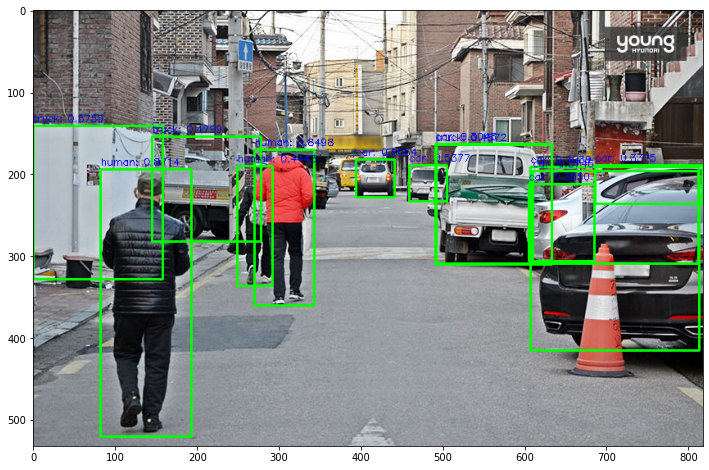

In [ ]:
import cv2

img_array = cv2.cvtColor(cv2.imread('/content/drive/MyDrive/이미지 1.jpg'), cv2.COLOR_BGR2RGB)

# scaling된 이미지 기반으로 bounding box 위치가 예측 되므로 이를 다시 원복하기 위해 원본 이미지 shape정보 필요
height = img_array.shape[0]
width = img_array.shape[1]
# cv2의 rectangle()은 인자로 들어온 이미지 배열에 직접 사각형을 업데이트 하므로 그림 표현을 위한 별도의 이미지 배열 생성. 
draw_img = img_array.copy()

# bounding box의 테두리와 caption 글자색 지정
green_color=(0, 255, 0)
red_color=(0, 0, 255)

# cv2로 만들어진 numpy image array를 tensor로 변환
img_tensor = tf.convert_to_tensor(img_array, dtype=tf.uint8)[tf.newaxis, ...]
#img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)[tf.newaxis, ...]

# pretrained 모델을 다운로드 한 뒤 inference 수행. 
result = detector_model(img_tensor)
# result 내부의 value를 numpy 로 변환. 
result = {key:value.numpy() for key,value in result.items()}

SCORE_THRESHOLD = 0.3
OBJECT_DEFAULT_COUNT = 100

# detected 된 object들을 iteration 하면서 정보 추출. detect된 object의 갯수는 100개
for i in range(min(result['detection_scores'][0].shape[0], OBJECT_DEFAULT_COUNT)):
  # detection score를 iteration시 마다 높은 순으로 추출하고 SCORE_THRESHOLD보다 낮으면 loop 중단. 
  score = result['detection_scores'][0, i]
  if score < SCORE_THRESHOLD:
    break
  # detected된 object들은 scale된 기준으로 예측되었으므로 다시 원본 이미지 비율로 계산
  box = result['detection_boxes'][0, i]

  ''' **** 주의 ******
   box는 ymin, xmin, ymax, xmax 순서로 되어 있음. '''
  left = box[1] * width
  top = box[0] * height
  right = box[3] * width
  bottom = box[2] * height

  # class id 추출하고 class 명으로 매핑
  class_id = result['detection_classes'][0, i]
  caption = "{}: {:.4f}".format(labels_to_names[class_id], score)
  print(caption)
  #cv2.rectangle()은 인자로 들어온 draw_img에 사각형을 그림. 위치 인자는 반드시 정수형.
  cv2.rectangle(draw_img, (int(left), int(top)), (int(right), int(bottom)), color=green_color, thickness=2)
  cv2.putText(draw_img, caption, (int(left), int(top - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, red_color, 1)

plt.figure(figsize=(12, 12))
plt.imshow(draw_img)

In [ ]:
import time

def get_detected_img(model, img_array, score_threshold, object_show_count=100, is_print=True):   
  # scaling된 이미지 기반으로 bounding box 위치가 예측 되므로 이를 다시 원복하기 위해 원본 이미지 shape정보 필요
  height = img_array.shape[0]
  width = img_array.shape[1]
  # cv2의 rectangle()은 인자로 들어온 이미지 배열에 직접 사각형을 업데이트 하므로 그림 표현을 위한 별도의 이미지 배열 생성. 
  draw_img = img_array.copy()

  # bounding box의 테두리와 caption 글자색 지정
  green_color=(0, 255, 0)
  red_color=(0, 0, 255)

  # cv2로 만들어진 numpy image array를 tensor로 변환
  img_tensor = tf.convert_to_tensor(img_array, dtype=tf.uint8)[tf.newaxis, ...]
  #img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)[tf.newaxis, ...]

  # efficientdet모델로 inference 수행. 
  start_time = time.time()
  # inference 결과로 내부 원소가 Tensor이 Dict 반환 
  result = model(img_tensor)
  # result 내부의 value를 numpy 로 변환. 
  result = {key:value.numpy() for key,value in result.items()}

  # detected 된 object들을 iteration 하면서 정보 추출. detect된 object의 갯수는 100개
  for i in range(min(result['detection_scores'][0].shape[0], object_show_count)):
    # detection score를 iteration시 마다 높은 순으로 추출하고 SCORE_THRESHOLD보다 낮으면 loop 중단. 
    score = result['detection_scores'][0, i]
    if score < score_threshold:
      break
    # detected된 object들은 scale된 기준으로 예측되었으므로 다시 원본 이미지 비율로 계산
    box = result['detection_boxes'][0, i]

    ''' **** 주의 ******
    box는 ymin, xmin, ymax, xmax 순서로 되어 있음. '''
    left = box[1] * width
    top = box[0] * height
    right = box[3] * width
    bottom = box[2] * height

    # class id 추출하고 class 명으로 매핑
    class_id = result['detection_classes'][0, i]
    caption = "{}: {:.4f}".format(labels_to_names[class_id], score)
    print(caption)
    #cv2.rectangle()은 인자로 들어온 draw_img에 사각형을 그림. 위치 인자는 반드시 정수형.
    cv2.rectangle(draw_img, (int(left), int(top)), (int(right), int(bottom)), color=green_color, thickness=2)
    cv2.putText(draw_img, caption, (int(left), int(top - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, red_color, 1)

  if is_print:
    print('Detection 수행시간:',round(time.time() - start_time, 2),"초")

  return draw_img

human: 0.8714
human: 0.8498
car: 0.7039
truck: 0.6759
car: 0.6054
car: 0.5377
truck: 0.4872
truck: 0.4799
human: 0.4443
Detection 수행시간: 0.37 초


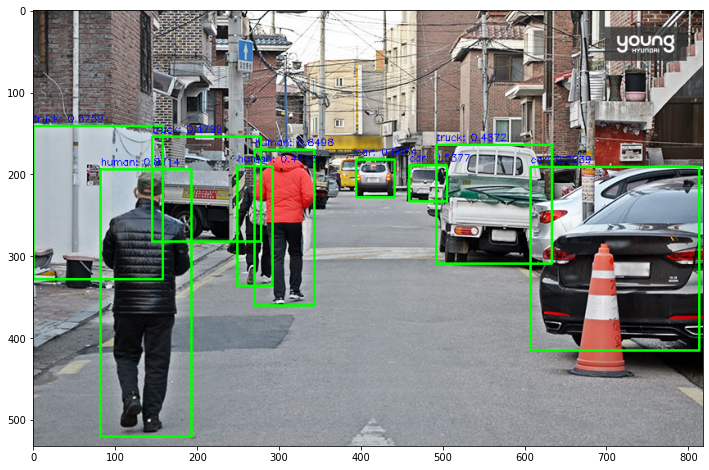

In [ ]:
img_array = cv2.cvtColor(cv2.imread('/content/drive/MyDrive/이미지 1.jpg'), cv2.COLOR_BGR2RGB)
draw_img = get_detected_img(detector_model, img_array, score_threshold=0.4, object_show_count=100, is_print=True)

plt.figure(figsize=(12, 12))
plt.imshow(draw_img)